# Generating useful features for further analysis on Amazon reviews

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
# movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to /Users/g/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 49.8 s, sys: 44.6 s, total: 1min 34s
Wall time: 2min 16s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [3]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [4]:
print(len(movies_tv))
print(movies_tv.head(5))

1697533
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [5]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

CPU times: user 5.46 s, sys: 95.2 ms, total: 5.56 s
Wall time: 5.85 s


In [6]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1: (45 min)

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

**Answer.** One possible solution is shown below:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12578d590>,
      dtype=object)

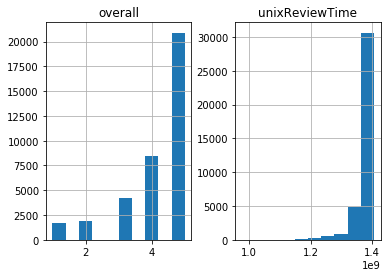

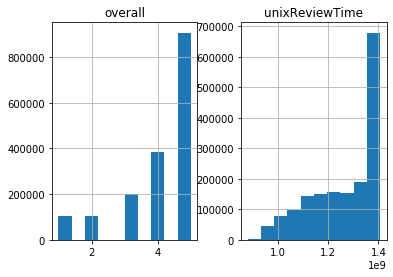

In [7]:
# Histograms
instant_video.hist()
movies_tv.hist()

We note that: 

1. Most reviews are good - in fact, more than half are perfect (5/5 stars) in both datasets!
2. Almost all instant video reviews are extremely recent. It will be very difficult to detect trends without correcting for this. The TV Movie reviews are substantially more spread out (though they also include a recent spike).

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

**Answer.** One possible solution is shown below:

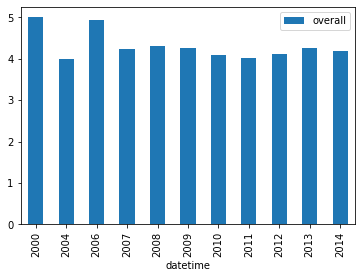

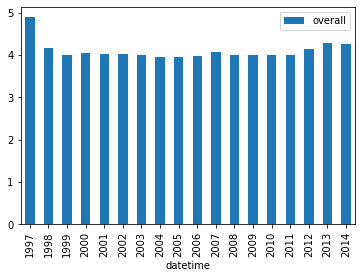

In [8]:
instant_video.groupby(instant_video.datetime.dt.year)['overall'].mean().to_frame().plot(kind="bar")
movies_tv.groupby(movies_tv.datetime.dt.year)['overall'].mean().to_frame().plot(kind="bar")

We note that:

* There are no noticeable trends of ratings changing over time
* There are some outlier years with higher ratings, but these are in the years where the number of reviews is very small, making the average less reliable

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

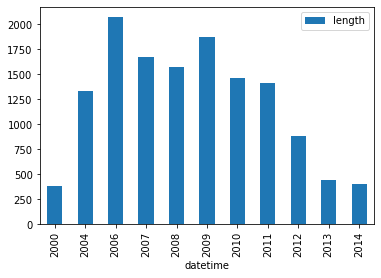

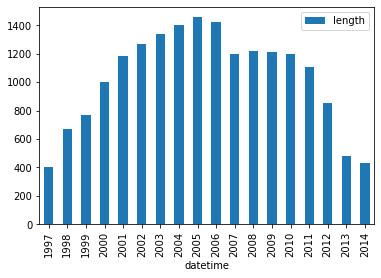

In [9]:
instant_video['length'] = instant_video['reviewText'].apply(len)
instant_video.groupby(instant_video.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

movies_tv['length'] = movies_tv['reviewText'].apply(len)
movies_tv.groupby(movies_tv.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

We note a seeming upward trend in review length through the 1990s and early 2000s, followed by a downtrend. Because both datasets have more recent reviews, the down-trend in review length is more reliable.

### Exercise 2: (60 min)

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

**Answer.** One possible solution is given below:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

short_movies_tv = movies_tv.head(100000)

def get_top_n_words(corpus, n=1, k=1):
    t1 = datetime.now()
    vec = CountVectorizer(ngram_range=(k, k), stop_words="english")
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

movie 146139
film 117896
like 49747
great 46391
good 44771
quot 44715
just 43336
time 39939
story 35359
really 29202
dvd 28395
best 27908
movies 25999
love 25779
watch 22436
people 21950
way 21529
don 21374
life 20965
films 20363
CPU times: user 14.5 s, sys: 259 ms, total: 14.8 s
Wall time: 14.9 s


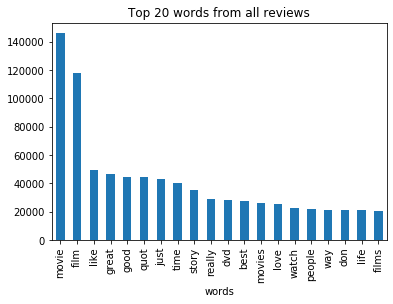

In [11]:
%%time
# All reviews
common_words = get_top_n_words(short_movies_tv["reviewText"], 20, 1)
for word, freq in common_words:
    print(word, freq)
    
df = pd.DataFrame(common_words, columns=["words", "count"])
df.groupby("words").sum()["count"].sort_values(ascending=False).plot(
    kind="bar", title="Top 20 words from all reviews"
)

movie 115580
film 93835
great 41013
like 37190
quot 34366
good 34320
time 32859
just 31716
story 28559
best 24257
dvd 23076
love 22405
really 22185
movies 21329
watch 18387
life 17972
people 17203
way 16891
films 16620
don 15604
CPU times: user 11.3 s, sys: 127 ms, total: 11.4 s
Wall time: 11.4 s


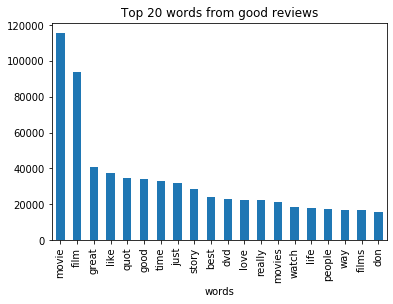

In [12]:
%%time

# Positive reviews
good_indices = short_movies_tv["overall"] > 3.1
good_reviews = short_movies_tv[good_indices]
bad_indices = short_movies_tv["overall"] < 2.1
bad_reviews = short_movies_tv[bad_indices]

common_words = get_top_n_words(good_reviews["reviewText"], 20)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=["words", 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from good reviews'
)

movie 16098
film 10802
like 6400
just 6185
quot 5348
good 4302
time 3401
really 3311
don 3164
story 3005
bad 2919
people 2603
dvd 2572
make 2366
movies 2350
better 2255
did 2202
way 2198
great 2185
character 2158
CPU times: user 1.6 s, sys: 35.8 ms, total: 1.63 s
Wall time: 1.64 s


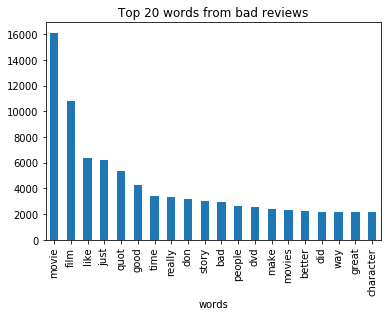

In [13]:
%%time

# Negative reviews
common_words = get_top_n_words(bad_reviews['reviewText'], 20)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from bad reviews'
)

Note that the results are almost identical across all three groups of reviews: almost all of the most important words are very common generic words about movies (i.e. "movie" itself). As we saw in the previous case, this is not that surprising - given that we are dealing with data in a movie specific context, and stop words will only account for generic words that appear across many English contexts, the most common non-stop words will be basic vocabulary related to movies, not necessarily more precise words that give more color to the reviews themselves.

 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

**Answer.** One possible solution is given below:

CPU times: user 4.88 s, sys: 228 ms, total: 5.11 s
Wall time: 5.12 s


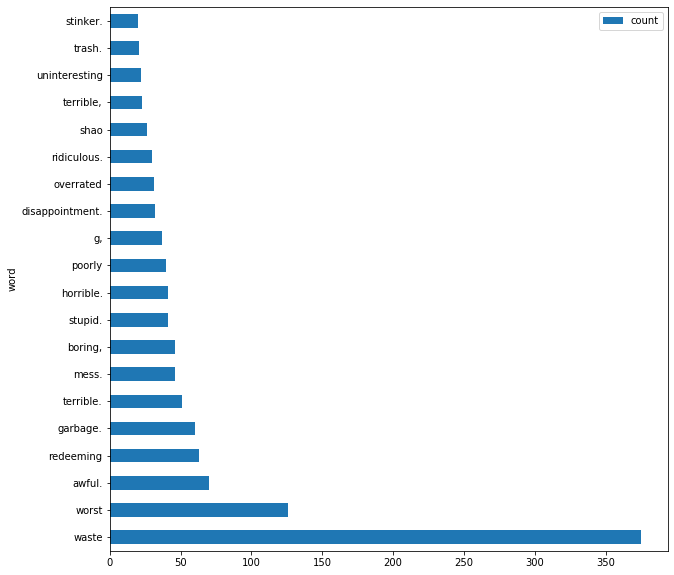

In [14]:
%%time
from collections import Counter

def get_indicative_words(text1, text2, n=20):
    c1 = Counter(text1.lower().split(" "))
    c2 = Counter(text2.lower().split(" "))
    ind_words_1 = (c1 - c2).most_common(n)
    ind_words_2 = (c2 - c1).most_common(n)    
    x, y = zip(*ind_words_2)
    
    df = pd.DataFrame({'word': x, 'count': y})
    df.plot.barh(
        x='word', y='count', figsize=(10,10)
    )

get_indicative_words(' '.join(good_reviews['reviewText']), ' '.join(bad_reviews['reviewText']))

We note that many of the words are obviously indicative of a bad movie, such as "horrible", "disappointment", "awful". "Redeeming" is an interesting word that doesn't have an obvious negative association, but it probably indicates that even in negative reviews reviewers tend to talk about a "one redeeming feature" (or state that the movie has no redeeming features). There is also some noise in the data, as is normal with text data. "g" and "shao" do not look like meaningful words.

### Exercise 3: (25 min)

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer.** One possible solution is given below. Note that the use of [Ansi escape codes](https://en.wikipedia.org/wiki/ANSI_escape_code) for colouring is a "nice extra" and not necessarily expected from student solutions:

In [15]:
v_bad_indices = movies_tv['overall'] < 1.1
v_bad_reviews = movies_tv[v_bad_indices]

RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

print(len(good_word_bad_review))
for rev in good_word_bad_review[:1000]:
    good_i = rev.lower().index("good")

    # we add Ansi codes to highlight the matches
    print(rev[good_i-50: good_i] + RED_START + rev[good_i:good_i+4] + END + rev[good_i+4:good_i +50])

27680
good, the story was correct, but naked backsides w
good but the scene with Yukon discovering peppermi
th absolutely NO edits whatsoever to the material.Good for us!Edits are for losers!I have spoken.
t least made it about an interesting story with a good plot and character development...i agree with
t everything I've seen thus far does not resemble good cinema in any shape, form, or manner. So, I g
itself is beautifully filmed. The acting is quite good and as a history freak I found it interesting
rtaining) and provides nothing that makes us feel good or is uplifting or is of any benefit, except 
ven if that person is Christ. The flashbacks were good and I'd rather have watched them than watched
to explain what singled out Christ as a symbol of good because a)he is a shallow and poor filmmaker 
 (and no-one could endure the pain).They say it's good to show the extent of the sacrifice that Jesu
good review when it was released, and I went to se
 story that everyone knows and of co

We see that "good" is used in a few very different ways in negative reviews. For example:

1. Sometimes the reviewer is pointing out something that is actually good, before saying that this doesn't make up for more important problems.
2. Sometimes the reviewer is saying that something good is not present, as in "almost everything I've seen thus far does not resemble good cinema in any shape, form, or manner."
3. Occasionally, the word "good" is referring to morality. 

How do these observations influence our future NLP efforts? Going in reverse order:

(3) Skimming through further reviews, we see that "good" is not used to refer to morality very often. This sense of the word is over-represented in our small sample above because "The Passion of the Christ" appears a few times amongst our first bad reviews. So we will put this off to the side in terms of guiding our next efforts for now.

(2) This is what we are most interested in - the word "good" used to reference *important* things that are not present. This is common throughout the dataset.

(1) This may be challenging for us to handle when we build models - it signals *unimportant* things that are good. Unfortunately, it is also quite common throughout the dataset!

These observations have a big impact on how we will process reviews. There are at least two distinct ways that negative reviews use the word "good" in a way that we care about, and a good analysis will not confuse them. There is no easy way to distinguish them by simple use of regular expressions. Instead, a more *global* analysis of the review is required. In future cases, you will learn about the concept of **polarity** which can assist with this.

### Exercise 4: (45 min)

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer.** One possible solution is shown below. Note this answer requires some experience with regular expressions. An answer more similar to the example answers for 2. and 3. is also possible.

In [16]:
import re

post_good = []
for sentence in good_word_bad_review:
    
    # extract the word following good. We strip non alpha characters for cases 
    # like the film was good--I enjoyed it.
    post = re.search("good.?\W*(\w+).*\s?", sentence, re.IGNORECASE)
    
    # if good is the last word in the review there will be no word 
    # directly following it, so ignore these cases.
    if post:
        post_good.append(post.groups()[0])
    
post_good = [i for i in post_good if i] 
print(post_good[0:10])

['the', 'but', 'for', 'plot', 'cinema', 'and', 'or', 'and', 'because', 'to']


In [17]:
# Answer to (ii)
# First, a function that extracts only "interesting" parts of speech
nltk.download('averaged_perceptron_tagger')
good_pos = ['CD', 'FW', 'NN', 'NNS', 'NNP', 'NNPS']

def extract_interesting(sentence, good):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k, v in nltk.pos_tag(words) if v in good]
    return(interesting)

# We use this to define a new function to extract the next "interesting" word
def next_word2(sentence):
    post = re.findall(r'good.*', sentence)
    if len(post) > 0:
        interesting = extract_interesting(post[0], good_pos)
        if (len(interesting) > 0):
            return(interesting[0])
        else:
            return('')
    else:
        return('')
    
# Finally, we actually find our list
post_good2 = []

for sentence in good_word_bad_review[:1000]:
    temp = next_word2(sentence)
    post_good2.append(temp)
    
post_good2 = [i for i in post_good2 if i] 
print(post_good2[0:10])


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/g/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['story', 'scene', 'plot', 'cinema', 'history', 'benefit', 'scenes.To', 'filmmaker', 'extent', 'review']


In [18]:
# Answer to (iii) 
# We define a function to extract all words *before* the first appearance of "good"

def prev_word(sentence):
    post = re.findall(r'.*?good', sentence)
    if (len(post) > 0):
        temp = extract_interesting(post[0],good_pos)
        if (len(temp) > 0):
            return(temp[len(temp)-1])
        else:
            return('')
    else:
        return('')
    
# Finally, we actually find our list
pre_good = []

for sentence in good_word_bad_review[:1000]:
    temp = prev_word(sentence)
    pre_good.append(temp)
    
pre_good = [i for i in pre_good if i] 
print(pre_good[0:10])

['acting', 'transfer', 'story', 'everything', 'acting', 'nothing', 'flashbacks', 'symbol', '.They', 'film']


### Exercise 5: (30 min)

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

**Answer.** One possible solution is shown below:

In [19]:
# We recall the following code for extracting the top k n-grams from a corpus
def get_top_n_words(corpus, n=1, k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

blu ray 6714
great movie 4300
ve seen 3895
special effects 3830
good movie 2669
love movie 2509
sci fi 2246
years ago 2191
movie great 2152
quot quot 1935
black white 1927
special features 1874
watch movie 1853
don know 1824
highly recommend 1812
year old 1799
seen movie 1774
new york 1720
great film 1683
real life 1471


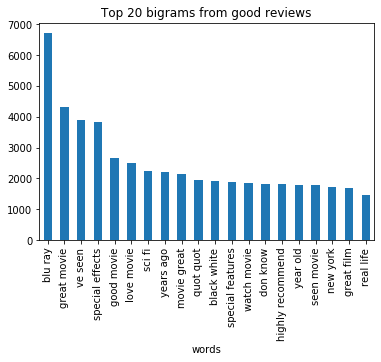

In [20]:
# We apply the function "get_top_n_words"  to the lists "GoodRev" and "BadRev"
# First, bigrams from good reviews
common_words = get_top_n_words(good_reviews['reviewText'], 20, 2)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams from good reviews'
)

tommy lee jones 779
nightmare elm street 640
does great job 467
world war ii 456
did great job 433
new york city 427
blu ray version 412
ve seen movie 383
highly recommend movie 350
based true story 344
blu ray release 316
does good job 310
did good job 283
country old men 273
special edition dvd 265
movie ve seen 262
dvd blu ray 251
haven seen movie 250
movies ve seen 247
does excellent job 216


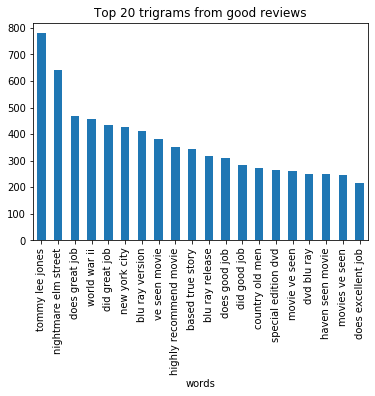

In [21]:
# Next, trigrams from good reviews
common_words = get_top_n_words(good_reviews['reviewText'], 20, 3)
for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns=['words', 'count'])
df.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams from good reviews'
)

Some of the bigrams and trigrams are clearly related to the topic but not necessarily to good reviews. For example "blu ray", "blu ray release", "tommy lee jones", "based true story".

Others are more obviously related specifically to good reviews, such as "does excellent job", "highly recommended", "great movie".

### Exercise 6: (15 min)

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.** Important words like "good" (as well as those appearing in the other n-grams above) tend to be adjectives. Adjectives describe nouns. More specifically, an adjective almost always describes the noun following it that is closest to it in a sentence. Sometimes adjectives are not directly after. For example, "This was a good -- and interesting -- movie" still has the "good" and "movie" linked together.

This suggests that we can use POS tagging to extract the locations of the adjectives and nouns, then iterate through all adjectives and count forward from each until we reach the next noun. These are our informative words.

### Exercise 7: (30 min)

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.** One possible solution is given below:

In [22]:
# We make a function that grabs the first adjective and its partner noun, then returns (i) the pair and (ii) a shorter sentence.

def grab_first_pair(sentence):
    words = nltk.word_tokenize(sentence)
    adjectives = [k for k, v in nltk.pos_tag(words) if v == 'JJ']
    if(len(adjectives) > 0):
        shorter = re.findall(adjectives[0] +'.*',sentence)[0]        
        words2 = nltk.word_tokenize(shorter)
        nouns = [k for k,v in nltk.pos_tag(words) if v == 'NN']
        if(len(nouns) > 0):
            shorter = shorter.split(' ', 1)[1]
            return(adjectives[0], nouns[0], shorter)
    return('', '', '')

# We make a function that uses the above to iterate through a sentence
def grab_all_pairs(sentence):
    pairs = []
    noun = ''
    adj =''
    while(len(sentence) > 0):
        adj, noun, sentence = grab_first_pair(sentence)
        if(adj != ''):
            pairs.append(adj + ' ' + noun)
    return(pairs)

# We make a function that iterates through many sentences after tokenizing
def make_pair_list(corpus):
    sentences = nltk.sent_tokenize(BigRev)
    pairs = []
    for sentence in sentences:
        pairs.extend(grab_all_pairs(sentence))

In [23]:
# We illustrate this 
sentence = "The big black dog scared the red cat."
print(grab_first_pair(sentence))
print(grab_all_pairs(sentence))

('big', 'dog', 'black dog scared the red cat.')
['big dog', 'black dog', 'red dog', 'red cat']
